# Python Spatial Analysis and Mapping

Agenda:
- python spatial analysis with geopandas
- projecting lat-long spatial data and shapefiles
- mapping with basemaps

### Quick overview of mapping and projections

##### Some terminology:
- **geoid**: (that's *gee-oid*) the surface of the earth's gravity field, which approximates mean sea level
- **spheroid** or **ellipsoid** (interchangeable terms): a model that smoothly approximates the geoid
- **datum**: based on spheroid but incorporates local variations in the shape of the Earth. Used to describe a point on the Earth's surface, such as in latitude and longitude.
  - NAD83 (North American Datum 1983) uses the GRS80 spheroid
  - WGS84 (World Geodetic Survey 1984 datum) uses the WGS84 spheroid
  - The latitude and longitude coordinates of some point differ slightly based on the datum. GPS uses WGS84.
- **coordinate reference system** (CRS) or spatial reference system (SRS): a series of parameters that [define](http://spatialreference.org/) the coordinate system and spatial extent (aka, domain) of some dataset.
- **geographic coordinate system** (GCS): specifies a datum, spheroid, units of measure (such as meters), and a prime meridian
- **projected coordinate system** or map projection: projects a map of the Earth's 3-D spherical surface onto a flat surface that can be measured in units like meters. Here's a [list of projections](http://www.remotesensing.org/geotiff/proj_list/).
- **eastings** and **northings**: the x and y coordinates of a projected map, usually measured in meters
- **false origin**: the 0,0 origin point from which eastings and northings are measured on the map, usually the lower left corner rather than the center
- **PROJ.4**: a library to convert/project spatial data with consistent CRS [parameter names](https://github.com/OSGeo/proj.4/wiki/GenParms)

##### Common CRS parameters (and their PROJ.4 names):
- datum (datum)
- ellipse (ellps)
- projection (proj)
  - the name of the projected coordinate system, such as Albers Equal Area (aea) or Lambert Conformal Conic (lcc)
- standard parallels (lat_1, lat_2)
  - where the projection surface touches the globe - at the standard parallels, the projection shows no distortion
- central meridian and latitude of origin (lon_0, lat_0)
  - the origin of the projection's x and y coordinates (eastings and northings) - usually the center of the map projection
- false easting and false northing (x_0, y_0)
  - offsets to add to all your eastings and northings - usually used to make all the coordinates on the map positive numbers by starting 0,0 at the lower left corner rather than the center of the map (see false origin, above)

##### Common projection types:
- *equal area* projections: maintain area at the expense of shape, distance, and direction - such as the [Albers Equal Area](http://www.remotesensing.org/geotiff/proj_list/albers_equal_area_conic.html) projection
- *conformal* projections: maintain shapes at the expense of area, distance, and direction - such as the [Lambert Conformal Conic](http://www.remotesensing.org/geotiff/proj_list/lambert_conic_conformal_2sp.html) projection
- *equidistant* projections: preserve distance from one point or along all meridians and parallels
- *azimuthal* projections: maintain direction from one point to all other points - such as an [orthographic](http://www.remotesensing.org/geotiff/proj_list/orthographic.html) projection
- others compromise to minimize overall distortion or aim for aesthetic value - such as the [Robinson](https://upload.wikimedia.org/wikipedia/commons/9/96/Robinson_projection_SW.jpg) projection

In [1]:
# magic command to display matplotlib plots inline within the ipython notebook
%matplotlib inline

# import necessary modules
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from geopandas import GeoDataFrame
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Point
from geopy.distance import great_circle

## Part 1: spatial analysis
We'll use [geopandas](http://geopandas.org/user.html), which spatializes pandas dataframes. 

In [2]:
# load usa point data and convert to geodataframe
df = pd.read_csv('data/usa-latlong.csv')
usa_points = GeoDataFrame(df)
usa_points.head()

,latitude,longitude
0,34.537094,-82.630303
1,35.025700,-78.970500
2,39.151817,-77.163810
3,38.636738,-121.319550
4,47.616955,-122.348921


In [3]:
# measure distance between the first two points in the dataset using geopy's great_circle function
# notice the points are represented as (lat, long) to do the distance calculation
point0 = usa_points.loc[0, 'latitude'], usa_points.loc[0, 'longitude']
point1 = usa_points.loc[1, 'latitude'], usa_points.loc[1, 'longitude']
great_circle(point0, point1).miles

210.46145350516352

In [4]:
# how far is each row from wurster hall?
def get_distance(row):
    wurster_hall = 37.870575, -122.254731
    distance = great_circle(wurster_hall, (row['latitude'], row['longitude'])).miles
    return round(distance, 2)

usa_points['miles_from_wurster'] = usa_points.apply(get_distance, axis=1)
usa_points.head()

,latitude,longitude,miles_from_wurster
0,34.537094,-82.630303,2205.22
1,35.025700,-78.970500,2392.86
2,39.151817,-77.163810,2414.71
3,38.636738,-121.319550,73.35
4,47.616955,-122.348921,673.62


In [5]:
# create a geometry column in our point dataset to contain shapely geometry for geopandas to use
# notice the points are represented as long, lat so that they are equivalent to x, y
usa_points['geometry'] = usa_points.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
usa_points.head()

,latitude,longitude,miles_from_wurster,geometry
0,34.537094,-82.630303,2205.22,POINT (-82.630303 34.537094)
1,35.025700,-78.970500,2392.86,POINT (-78.9705 35.0257)
2,39.151817,-77.163810,2414.71,POINT (-77.16381 39.151817)
3,38.636738,-121.319550,73.35,POINT (-121.31955 38.636738)
4,47.616955,-122.348921,673.62,POINT (-122.348921 47.616955)


In [6]:
# load the states shapefile as a geodataframe
states = GeoDataFrame.from_file('data/states_21basic/states.shp')
states.head()

,DRAWSEQ,STATE_ABBR,STATE_FIPS,STATE_NAME,SUB_REGION,geometry
0,1,HI,15,Hawaii,Pacific,(POLYGON ((-160.0738033454682 22.0041773479577...
1,2,WA,53,Washington,Pacific,(POLYGON ((-122.4020153103836 48.2252163723779...
2,3,MT,30,Montana,Mountain,POLYGON ((-111.4754253002074 44.70216236909688...
3,4,ME,23,Maine,New England,(POLYGON ((-69.77727626137293 44.0741483685119...
4,5,ND,38,North Dakota,West North Central,POLYGON ((-98.73043728833767 45.93827137024809...


In [7]:
# what's in our shapefile?
print len(states)
states['STATE_NAME'].unique()

51


array([u'Hawaii', u'Washington', u'Montana', u'Maine', u'North Dakota',
       u'South Dakota', u'Wyoming', u'Wisconsin', u'Idaho', u'Vermont',
       u'Minnesota', u'Oregon', u'New Hampshire', u'Iowa',
       u'Massachusetts', u'Nebraska', u'New York', u'Pennsylvania',
       u'Connecticut', u'Rhode Island', u'New Jersey', u'Indiana',
       u'Nevada', u'Utah', u'California', u'Ohio', u'Illinois',
       u'District of Columbia', u'Delaware', u'West Virginia', u'Maryland',
       u'Colorado', u'Kentucky', u'Kansas', u'Virginia', u'Missouri',
       u'Arizona', u'Oklahoma', u'North Carolina', u'Tennessee', u'Texas',
       u'New Mexico', u'Alabama', u'Mississippi', u'Georgia',
       u'South Carolina', u'Arkansas', u'Louisiana', u'Florida',
       u'Michigan', u'Alaska'], dtype=object)

In [8]:
# get those states that intersect with the point data
# use geopandas unary_union attribute to get a single geometry object representing all the points
mask = states['geometry'].intersects(usa_points['geometry'].unary_union)
states_with_points = states[mask]

len(states_with_points)

49

In [9]:
# which states didn't have any point data?
states[~mask]['STATE_NAME']

4    North Dakota
6         Wyoming
Name: STATE_NAME, dtype: object

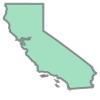

In [10]:
# get the geometry of the state with name california, as a geoseries of one element
california = states[states['STATE_NAME']=='California']['geometry']

# use iloc to extract the value from a geoseries of one element, to a shapely polygon
california_polygon = california.iloc[0]
california_polygon

In [11]:
# another example: remove any point data that lies within Alaska or Hawaii
# first grab the polygons from these states' geoseries using iloc
alaska_polygon = states[states['STATE_NAME']=='Alaska']['geometry'].iloc[0]
hawaii_polygon = states[states['STATE_NAME']=='Hawaii']['geometry'].iloc[0]

# now use a mask to select all points *not* within either state's polygon
alaska_hawaii_mask = usa_points.within(alaska_polygon) | usa_points.within(hawaii_polygon)
usa_points = usa_points[~alaska_hawaii_mask]

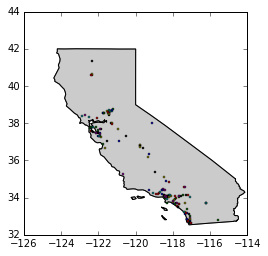

In [12]:
# visual example of selecting points geographically: which points are in california?
california_points = usa_points[usa_points.within(california_polygon)]

# plot california geoseries and the geoseries of points within california polygon
california.plot()
california_points.plot()

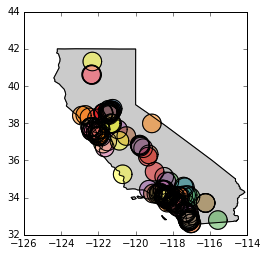

In [13]:
# you can easily calculate buffers (and then perform intersections with them)
california.plot()
california_points.buffer(0.5).plot()

But these buffers are kind of weird because the data is not projected - it's all in lat-long degrees. Let's project it.

## Part 2: projecting spatial data

Let's define a projection we can use to convert and map our lat-long data. The parameters in the following dictionaries correspond to the projection parameters from PROJ4. Geopandas uses the pyproj library to convert spatial data, which in turn uses PROJ4 projection names and parameters.

You can figure out these parameter values either by approximating the lats and longs of your spatial data set, or by trial and error, or by looking up a reference like [this one](http://spatialreference.org/ref/epsg/26911/) for UTM zone 11. 

Geopandas needs your projection to be specified in a dict - you can create one manually, or use the function below to convert a PROJ4 string to a dict.

In [14]:
# option 1: specify your projections manually as python dicts
# we'll map with UTM zone 11 which is good for California - this is a projected coordinate system
utm_11 = {'datum':'NAD83',
          'ellps':'GRS80',
          'proj':'utm',
          'zone':11,
          'units':'m'}

In [15]:
# option 2: pass an existing proj4 string to this function and it'll turn it into a python dict
def proj4_to_dict(proj4string):
    params_dict = {}
    proj4string = proj4string.strip('+') #strip preceding +
    for param_pair in proj4string.split(' +'): #break string into tokens
        key_value = param_pair.split('=') #break token by parameter=value
        if len(key_value)==2: #if there aren't 2 pieces (param and value), ignore it
            key, value = tuple(key_value)
        params_dict[key] = value
    return params_dict

In [16]:
# test the function out
proj4 = '+proj=utm +zone=11 +ellps=GRS80 +datum=NAD83 +units=m +no_defs'
utm_11 = proj4_to_dict(proj4)
utm_11

{'datum': 'NAD83', 'ellps': 'GRS80', 'proj': 'utm', 'units': 'm', 'zone': '11'}

In [17]:
# you must specify the geodataframe's original CRS (if it doesn't already have one) so geopandas knows how to project it
# the GPS data is lat-long and its datum/ellipsoid is WGS84 - this is a geographic coordinate system
original_crs = {'datum':'WGS84', 'ellps':'WGS84', 'proj':'latlong'}
california_points.crs = original_crs

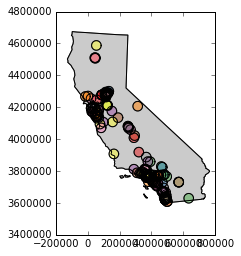

In [18]:
# the california shapefile already has an original CRS so we don't need to specify it - just project and plot it
california = california.to_crs(utm_11)
california.plot()

# now project the point data to the projected coordinate system, draw buffers, and plot it
california_points = california_points.to_crs(utm_11)
california_points.buffer(30000).plot()

So that's our projected data and shapefile. Notice how the shape has changed, and how the units make more sense - they are in meters now. So our buffers are a 30km radius from each point.

It's also easy to save a geodataframe as a shapefile or as a geojson string (for easy leaflet mapping):

In [19]:
# save projected shapefile
california.to_file('data/ca_utm_11/', driver='ESRI Shapefile')

# convert un-projected point data and shapefile to geojson strings (you can then copy/paste these or save them to a file)
points_geojson = usa_points.to_json()
states_geojson = states.to_json()

Now let's project our entire USA points data to a projection appropriate for the entire USA. We'll specify the datum, ellipsoid, projection name, standard parallels, central meridian and latitude of origin, false easting and false northing (because matplotlib basemap sticks the origin at the lower left corner), and measurement units. 

In [20]:
# set our usa_points dataset's original CRS
usa_points.crs = original_crs
usa_points.head()

,latitude,longitude,miles_from_wurster,geometry
0,34.537094,-82.630303,2205.22,POINT (-82.630303 34.537094)
1,35.025700,-78.970500,2392.86,POINT (-78.9705 35.0257)
2,39.151817,-77.163810,2414.71,POINT (-77.16381 39.151817)
3,38.636738,-121.319550,73.35,POINT (-121.31955 38.636738)
4,47.616955,-122.348921,673.62,POINT (-122.348921 47.616955)


In [21]:
# specify the width and height of the map extent/domain in projection coordinate units (meters) - approx USA dimensions
map_width_m = 5000 * 1000 #5000 km
map_height_m = 3500 * 1000 #3500 km

In [22]:
# Albers Conical Equal Area projection for USA
albers_usa = {'datum':'NAD83',
              'ellps':'GRS80',
              'proj':'aea', 
              'lat_1':33, 
              'lat_2':45, 
              'lon_0':-97, 
              'lat_0':39, 
              'x_0':map_width_m/2, 
              'y_0':map_height_m/2,
              'units':'m'}

In [23]:
# now you can convert the point data to a projected CRS
target_crs = albers_usa
usa_points = usa_points.to_crs(target_crs)
usa_points.head()

,latitude,longitude,miles_from_wurster,geometry
0,34.537094,-82.630303,2205.22,POINT (3810700.428966678 1355670.344562949)
1,35.025700,-78.970500,2392.86,POINT (4130004.501077836 1467971.140232016)
2,39.151817,-77.163810,2414.71,POINT (4191992.744538558 1950989.928778354)
3,38.636738,-121.319550,73.35,POINT (418673.1364585953 1987565.730143212)
4,47.616955,-122.348921,673.62,POINT (606046.7645739054 2972874.652640361)


In [24]:
# convert the projected points into discrete x and y columns for easy matplotlib scatter-plotting
usa_points['x'] = usa_points['geometry'].map(lambda point: point.x)
usa_points['y'] = usa_points['geometry'].map(lambda point: point.y)
usa_points.head()

,latitude,longitude,miles_from_wurster,geometry,x,y
0,34.537094,-82.630303,2205.22,POINT (3810700.428966678 1355670.344562949),3810700.428967,1355670.344563
1,35.025700,-78.970500,2392.86,POINT (4130004.501077836 1467971.140232016),4130004.501078,1467971.140232
2,39.151817,-77.163810,2414.71,POINT (4191992.744538558 1950989.928778354),4191992.744539,1950989.928778
3,38.636738,-121.319550,73.35,POINT (418673.1364585953 1987565.730143212),418673.136459,1987565.730143
4,47.616955,-122.348921,673.62,POINT (606046.7645739054 2972874.652640361),606046.764574,2972874.652640


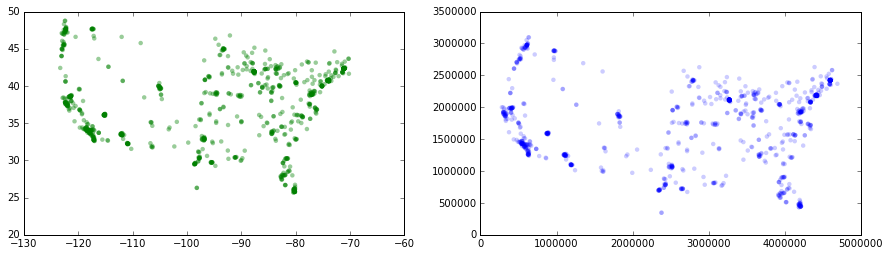

In [25]:
# scatter plot un-projected and projected point data side by side
fig, ax = plt.subplots(1, 2, figsize=[15,4])
ax[0].scatter(x=usa_points['longitude'], y=usa_points['latitude'], c='g', edgecolor='None', alpha=0.4)
ax[1].scatter(x=usa_points['x'], y=usa_points['y'], c='b', edgecolor='None', alpha=0.2)
plt.show()

Unprojected lat-long data (left) and projected data (right). The origin on the right is 0,0 like we'd expect for our false origin. Now let's make it look nice, with matplotlib basemap.

# Part 3: basemaps

We'll use the matplotlib basemap toolkit

- User's guide and installation instructions: http://matplotlib.org/basemap/
- Documentation: http://matplotlib.org/basemap/api/basemap_api.html
- You can find color codes from a site like this: http://html-color-codes.info/

In [26]:
# define basemap colors
land_color = '#F6F6F6'
water_color = '#D2F5FF'
coastline_color = '#333333'
border_color = '#999999'

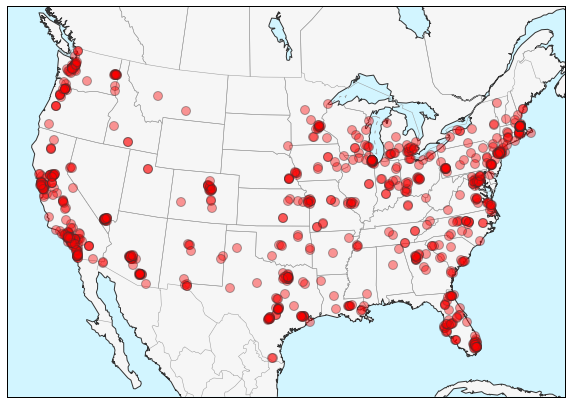

In [27]:
plt.figure(figsize=[10,7]) #same ratio as map_width_m:map_height_m so we don't stretch it

m = Basemap(ellps=target_crs['ellps'],
            projection=target_crs['proj'],
            lat_1=target_crs['lat_1'], 
            lat_2=target_crs['lat_2'], 
            lon_0=target_crs['lon_0'], 
            lat_0=target_crs['lat_0'],
            width=map_width_m, 
            height=map_height_m,
            resolution='l', #l means low resolution boundaries
            area_thresh=10000) #coastline or lake with an area smaller than this km^2 will not be plotted

m.drawcoastlines(color=coastline_color)
m.drawcountries(color=border_color)
m.fillcontinents(color=land_color, lake_color=water_color)
m.drawstates(color=border_color)
m.drawmapboundary(fill_color=water_color)

m.scatter(x=usa_points['x'], y=usa_points['y'], s=80, color='r', edgecolor='#333333', alpha=0.4, zorder=10)

plt.show()

In [28]:
# subset the usa_points by within/not within colorado to scatter plot them differently
colorado = states[states['STATE_NAME']=='Colorado']['geometry']
colorado_polygon = colorado.to_crs(target_crs).iloc[0] #project our shapefile to the same CRS we just used
colorado_mask = usa_points.within(colorado_polygon) #for each point, returns true if within colorado, false if not
colorado_points = usa_points[colorado_mask] #get all the points within colorado
non_colorado_points = usa_points[~colorado_mask] #get all the points not within colorado

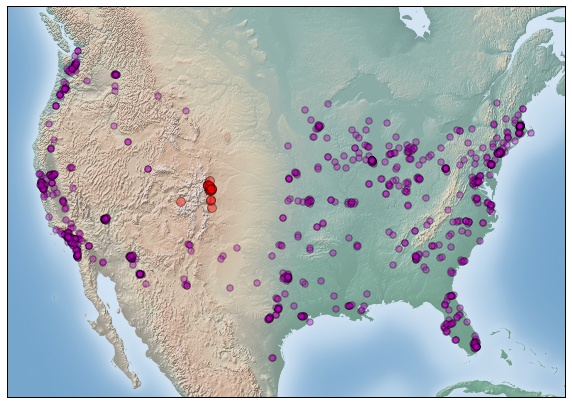

In [29]:
# draw a shaded relief map of North America then scatterplot colorado points in red, all others in purple
plt.figure(figsize=[10,7])
m = Basemap(ellps=target_crs['ellps'],
            projection=target_crs['proj'],
            lat_1=target_crs['lat_1'], 
            lat_2=target_crs['lat_2'], 
            lon_0=target_crs['lon_0'], 
            lat_0=target_crs['lat_0'],
            width=map_width_m, 
            height=map_height_m,
            resolution=None, #don't plot boundaries because we're doing shaded relief instead
            area_thresh=10000)

# draw a shaded relief map for this domain
m.shadedrelief()

# scatter plot our colorado points in red and everything else in purple
m.scatter(x=colorado_points['x'], y=colorado_points['y'], s=80, color='r', edgecolor='k', alpha=0.4, zorder=10)
m.scatter(x=non_colorado_points['x'], y=non_colorado_points['y'], s=40, color='m', edgecolor='k', alpha=0.4, zorder=10)
plt.show()

In [30]:
# define an orthographic projection
ortho_usa = {'datum':'WGS84',
             'ellps':'WGS84',
             'proj':'ortho',  
             'lon_0':-105., 
             'lat_0':40.,
             'units':'m'}

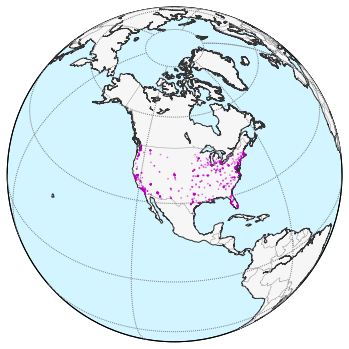

In [31]:
# draw an orthographic projection looking down on North America from orbit
plt.figure(figsize=[6,6])
m = Basemap(projection=ortho_usa['proj'],
            lon_0=ortho_usa['lon_0'],
            lat_0=ortho_usa['lat_0'],
            resolution='l',
            area_thresh=10000)

m.drawcoastlines(color=coastline_color)
m.fillcontinents(color=land_color,lake_color=water_color)
m.drawmapboundary(fill_color=water_color)
m.drawcountries(color=border_color)

# add lines of longitude and latitude to give the globe perspective
m.drawparallels(np.arange(-90., 120., 30.), color='gray')
m.drawmeridians(np.arange(0., 420., 60.), color='gray')

# we can use basemap to project our data into the current map projection
x, y = m(np.array(usa_points['longitude']), np.array(usa_points['latitude']))
m.scatter(x=x, y=y, s=3, color='m', edgecolor='None', alpha=0.5, zorder=10)
plt.show()

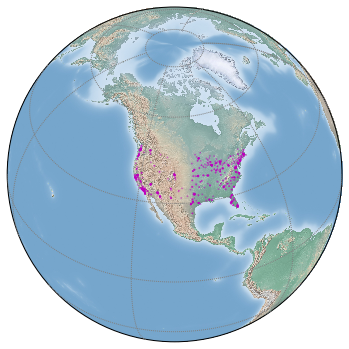

In [32]:
# combine an orthographic projection with shaded relief
plt.figure(figsize=[6,6])
m = Basemap(projection=ortho_usa['proj'],
            lon_0=ortho_usa['lon_0'],
            lat_0=ortho_usa['lat_0'],
            resolution=None)

# draw the shaded relief and parallels/meridians
m.shadedrelief()
m.drawparallels(np.arange(-90., 120., 30.), color='gray')
m.drawmeridians(np.arange(0., 420., 60.), color='gray')

# project and plot our lat-long data
x, y = m(np.array(usa_points['longitude']), np.array(usa_points['latitude']))
m.scatter(x=x, y=y, s=3, color='m', edgecolor='None', alpha=0.5, zorder=10)
plt.show()

### Final example: plot projected Europe data, from scratch

One last simple example, showing how easy it is to project and map spatial data from scratch in just a few lines of code.

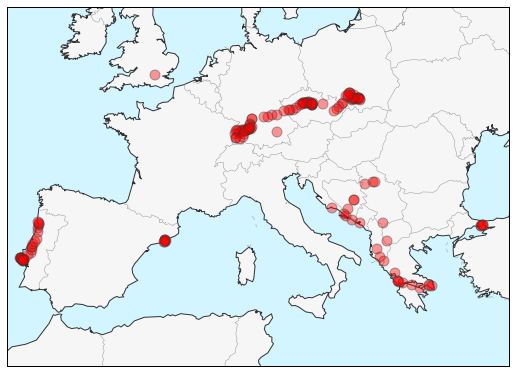

In [33]:
# load the Europe GPS data
df = pd.read_csv('data/summer-travel-gps-dbscan.csv')

# specify map width and height with approx Europe dimensions
map_width_m = 3500 * 1000 #3500 km
map_height_m = 2500 * 1000 #2500 km
plt.figure(figsize=[9, 9*(map_height_m/float(map_width_m))]) #make plot the same height:width ratio

# Albers Conical Equal Area projection for Europe
m = Basemap(ellps='WGS84', projection='aea', lat_1=35, lat_2=55, lon_0=10, lat_0=45,
            width=map_width_m, height=map_height_m, resolution='l', area_thresh=10000)

m.drawcoastlines(color=coastline_color)
m.drawcountries(color=border_color)
m.fillcontinents(color=land_color, lake_color=water_color)
m.drawmapboundary(fill_color=water_color)

# project and plot our lat-long data
x, y = m(np.array(df['lon']), np.array(df['lat']))
m.scatter(x=x, y=y, s=100, color='r', edgecolor='#333333', alpha=0.4, zorder=10)

plt.show()

So what's the point of all this? Why not just use QGIS? Well if I'm just trying to make a one-off map, I'd just use QGIS. But if I were automating a workflow, I'd use Python: geopandas and basemap are fast for projecting, mapping, and spatial analysis especially when it's repetitive. But most of all, if I'm already working with pandas data, cleaning it, analyzing it, modeling it - I can create a nice map of it with just a few more lines of code.

If you're interested in more fine-grained control over plotting your basemap, you can project a shapefile and convert each piece of geometry inside it into a patch for matplotlib to plot (individually customizable). I describe this process in an old blog post I wrote: http://geoffboeing.com/2014/09/visualizing-summer-travels-part-6-projecting-spatial-data-python/